In [103]:
import matplotlib
matplotlib.use("TkAgg")
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
import gym
#import gridworld
from gym import wrappers, logger
import numpy as np
import copy
from torch import nn
from torch import FloatTensor
from torch import *
import torch
import random
from collections import namedtuple, deque
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
from torchvision import transforms
import torch.distributions as tdist
from collections import OrderedDict

In [2]:
BUFFER_SIZE = 100
BATCH_SIZE = 10

class ExperienceReplay(object):
    
    def __init__(self, buffer_size = BUFFER_SIZE, batch_size = BATCH_SIZE):
        super().__init__()
        self.batch_size = batch_size
        self.buffer = deque(maxlen = buffer_size)
        self.experience =  namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        
    def store(self, experience):
        self.buffer.append(experience)
        
    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        state = torch.stack([torch.tensor(exp.state) for exp in batch])
        action = torch.stack([torch.tensor(exp.action) for exp in batch])
        reward = torch.stack([torch.tensor(exp.reward) for exp in batch])
        next_state = torch.stack([torch.tensor(exp.next_state) for exp in batch])
        done = torch.stack([torch.tensor(exp.done) for exp in batch])
        
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)
    
    


In [145]:
class Net(nn.Module):
    
    def __init__(self, inSize, outSize, layers, policy=True):
        super(Net, self).__init__()
        self.layers = nn.ModuleList([])
        for x in layers:
            self.layers.append(nn.Linear(inSize, x))
            inSize = x
        self.layers.append(nn.Linear(inSize, outSize))
        self.policy = policy
            
    def forward(self, x):
        x = x.double()
        x = self.layers[0](x)
        for i in range(1, len(self.layers)):
            x = torch.nn.functional.leaky_relu(x.double())
            x = self.layers[i](x).double()
        if self.policy:
            x = (torch.tanh(x)*.5+.5)*(2)-1
        return x

In [4]:
class Orn_Uhlen:
    def __init__(self, n_actions, mu=0, theta=0.15, sigma=0.2):
        self.n_actions = n_actions
        self.X = np.ones(n_actions) * mu
        self.mu = mu
        self.sigma = sigma
        self.theta = theta

    def reset(self):
        self.X = np.ones(self.n_actions) * self.mu

    def sample(self):
        dX = self.theta * (self.mu - self.X)
        dX += self.sigma * np.random.randn(self.n_actions)
        self.X += dX
        return torch.tensor(self.X).squeeze(0)

In [147]:
if __name__ == '__main__':

    ### parameters ###
    BUFFER_SIZE = 400
    BATCH_SIZE = 100

    GAMMA = 0.99
    
    RHO = 0.99 #Polyak averaging

    ### Environment setting ###
    env_name = 'MountainCarContinuous-v0'
    env_name = 'Pendulum-v0'
    env = gym.make(env_name)
    outdir = 'MountainCarContinuous-v0/ddpg-agent-results'
    envm = wrappers.Monitor(env, directory=outdir, force=True, video_callable=False)
    env.seed(0)
    env.reset()
    verbose = False
    done = False
    
    outSize = 1
    layers_actors = [200, 200]
    layers_critics = [200, 200]
    state_size = env.observation_space.shape[0]
    #inSize_actor = envm.reset().size
    #inSize_critic = inSize_actor + 1
    
    ### Initialization ###  Policy and value networks + Experience replay
    exp_replay = ExperienceReplay(BUFFER_SIZE, BATCH_SIZE)
    
    target_critic = Net(state_size+1, outSize, layers_critics, policy=False).double()
    critic = Net(state_size+1, outSize, layers_critics, policy=False).double()
    
    target_actor =  Net(state_size, outSize, layers_actors).double()
    actor =  Net(state_size, outSize, layers_actors).double()

    
    ### Training Settings ###
    episode_count = 3000
    
    #params = list(list(critic.parameters()) + list(actor.parameters()))
    
    optimizer_actor = optim.Adam(actor.parameters(), lr=1e-4)
    optimizer_critic = optim.Adam(critic.parameters(),lr =1e-3)
    
    MSE_loss = nn.MSELoss()
    rsum_hist = []
    
    # exploration noise
    noise = Orn_Uhlen(1, mu=0.0, theta=0.15, sigma=.3)
    noise = OUNoise(env.action_space)

    ### Training loop ###

    for episode in range(episode_count):

        it = 0
        obs = envm.reset()

        rsum = 0.0
        done = False

        while(True):

            state = obs
               
            action = actor.forward(torch.tensor(state)).detach() #+ noise.sample()
            
            #action =  torch.clamp(action, env.action_space.low[0], env.action_space.high[0])
            action = noise.get_action(action.numpy())
            obs, reward, done, _ = envm.step(action)
            

            rsum += reward.item()
            
            if verbose == True:

                env.render()

            ### storing experience ###
            exp = exp_replay.experience(state, action, reward, obs, done)
            exp_replay.store(exp)

            if len(exp_replay) > BATCH_SIZE:

                ### sampling batchs ###
                states, actions, rewards, next_states, dones = exp_replay.sample()
            
                ### Updating DDPG agent ###
                optimal_actions = target_actor.forward(next_states).detach()
                
                states_optimal_actions = torch.cat((next_states, optimal_actions), dim=1).detach()
                
                q_targets = rewards + GAMMA * target_critic.forward(states_optimal_actions).detach() * (1.0 - dones.double().reshape(BATCH_SIZE, -1))
                

                ### actor : forward + Computing loss + backprop ###
                optimizer_critic.zero_grad()
                
                states_actions = torch.cat((states, actions), dim=1)

                q_estimates = critic.forward(states_actions)

                critic_loss = MSE_loss(q_estimates, q_targets.detach())
                
                critic_loss.backward()

                optimizer_critic.step()
                
                ### critic : forward + Computing loss + backprop ###
                optimizer_actor.zero_grad()
                
                actor_actions = actor.forward(states)
                
                states_actor_actions = torch.cat((states, actor_actions), dim=1)

                q_values = critic.forward(states_actor_actions)

                actor_loss = - torch.mean(q_values)
                
                actor_loss.backward()

                optimizer_actor.step()
                
                
            params1 = actor.state_dict()
            params2 = target_actor.state_dict()
            dict_params2 = dict(params2)
            
            for name1, param1 in params1.items():
                if name1 in dict_params2:
                    dict_params2[name1].data.copy_(RHO*param1.data + (1-RHO)*dict_params2[name1].data)
                
            #target_actor.load_state_dict(dict_params2)

            params1 = critic.state_dict()
            params2 = target_critic.state_dict()
            dict_params2 = dict(params2)
            
            for name1, param1 in params1.items():
                if name1 in dict_params2:
                    dict_params2[name1].data.copy_(RHO*param1.data + (1-RHO)*dict_params2[name1].data)
                
            #target_critic.load_state_dict(dict_params2)
 

            if done == True:
                print("Episode : " + str(episode) + " rsum=" + str(rsum) + "critic loss :" + str(critic_loss.item()) + ",actor loss :" + str(actor_loss.item())+  ", iter = "+ str(it))
                rsum_hist.append(rsum)
                noise.reset()
                break

            it += 1

Episode : 0 rsum=-1187.2482992019904critic loss :113.65660977359794,actor loss :153.44429106112534, iter = 199
Episode : 1 rsum=-1390.545115554865critic loss :268.71526186154017,actor loss :149.47195939126988, iter = 199
Episode : 2 rsum=-1198.4013744355768critic loss :1682.2722708194121,actor loss :265.1196860250399, iter = 199
Episode : 3 rsum=-1464.9397670232113critic loss :115.1503882663386,actor loss :231.9239957382383, iter = 199
Episode : 4 rsum=-1287.3466861785785critic loss :9085.18513539528,actor loss :607.585023370009, iter = 199
Episode : 5 rsum=-1109.413566419528critic loss :52.14677603171118,actor loss :161.60677736750043, iter = 199
Episode : 6 rsum=-1685.417695265205critic loss :2309.5101103400243,actor loss :338.8959730725974, iter = 199
Episode : 7 rsum=-1198.863515246085critic loss :110.4302577041154,actor loss :361.5746051435251, iter = 199
Episode : 8 rsum=-1549.3279480362528critic loss :160.5358702380562,actor loss :275.6414533136226, iter = 199
Episode : 9 rsum=-

Episode : 75 rsum=-1294.1748871630218critic loss :86.85339077258917,actor loss :369.0020762615054, iter = 199
Episode : 76 rsum=-1311.686145099311critic loss :183.40746130068663,actor loss :427.95044758664335, iter = 199


KeyboardInterrupt: 

In [79]:
env.close()

In [74]:
class OUNoise(object):
    """ Ornstein-Ulhenbeck Process
    from https://github.com/vitchyr/rlkit/blob/master/rlkit/exploration_strategies/ou_strategy.py
    """
    def __init__(self, action_space, mu=0.0, theta=0.15, max_sigma=0.3, min_sigma=0.3, decay_period=100000):
        self.mu           = mu
        self.theta        = theta
        self.sigma        = max_sigma
        self.max_sigma    = max_sigma
        self.min_sigma    = min_sigma
        self.decay_period = decay_period
        self.action_dim   = action_space.shape[0]
        self.low          = action_space.low
        self.high         = action_space.high
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dim) * self.mu

    def evolve_state(self):
        x  = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.action_dim)
        self.state = x + dx
        return self.state

    def get_action(self, action, t=0):
        ou_state = self.evolve_state()
        self.sigma = self.max_sigma - (self.max_sigma - self.min_sigma) * min(1.0, t / self.decay_period)
        return np.clip(action + ou_state, self.low, self.high).astype(action.dtype)

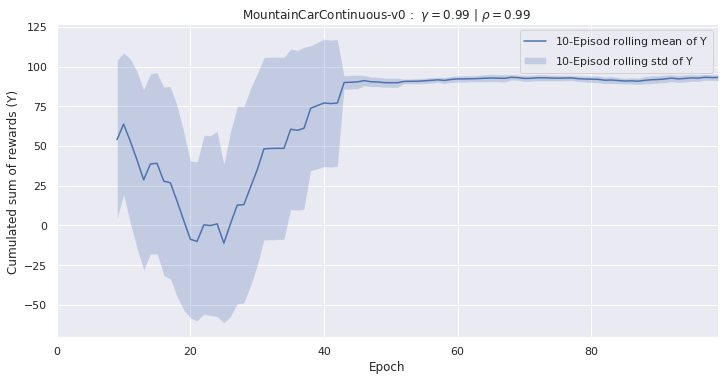

In [195]:
import pandas as pd
import seaborn as sns
sns.set() 
window = 10

env_name = 'MountainCarContinuous-v0'
data = pd.concat([pd.Series(rsum_hist, name='mean').rolling(window).mean(),
          pd.Series(rsum_hist, name='std').rolling(window).std()],
          axis=1)

sns.set()
plt.figure(figsize=(10,5))
ax = data['mean'].plot()

ax.fill_between(data.index, data['mean'] - data['std'], data['mean'] + data['std'],
                alpha=.25)
plt.tight_layout()
plt.ylabel("Cumulated sum of rewards (Y)")

title = r'%s :  $\gamma = %.2f$ | $\rho=%.2f$ '%(env_name, GAMMA, RHO)
    
plt.title(title)

plt.legend(['$%d$-Episod rolling mean of Y'%window, '$%d$-Episod rolling std of Y'%window])
plt.xlabel('Epoch')
sns.despine()